In [2]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, goldmine_behavior

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

## Perform alignment

In [3]:
subj_sess = 'U530_ses1'

# Read events file and get event synctimes.
events, event_synctimes = events_preproc.read_events_json(subj_sess)

# Load LFP timestamps.
lfp_timestamps, sr = spike_sorting.load_lfp_timestamps(subj_sess)

# Load the sync channel.
sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')

# Identify sync pulses in the sync channel EEG.
pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                   sampling_rate=sr, 
                                                   pulse_thresh=200, 
                                                   intrapulse_thresh_ms=20, 
                                                   interpulse_thresh_ms=790)
lfp_synctimes = lfp_timestamps[pulse_startinds]
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

# Find matching sync pulse pairs.
event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                         lfp_synctimes)

# Perform the alignment.
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes_adj)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
print('\n--------------------\nAlignment parameters\n--------------------')
for k, v in alignment.items():
    print('{}: {}'.format(k, v))

82427 events recorded over 64 min and 42 sec
Conversion factor is 1
117432666 timestamps over 65 min and 14.4 s
Sampling rate is 30000 Hz
Detected 3887 EEG sync pulses
Detected 3887 syncs for 3879 sync pulse events
Retained 3775 sync pulses
3775 event sync pulses
3775 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
sync_params: OrderedDict([('intercept', 28655.631209836047), ('slope', 1.000014481219782)])
before_stats: OrderedDict([('ipi_r', 0.9999997442643491), ('ipi_diff', 0.17886390814596217), ('rmse', 28683.747780127796), ('err_pcts', 0      28656.469873
1      28656.883223
5      28658.653975
10     28661.169339
25     28669.743343
50     28683.876725
75     28697.741545
90     28705.887376
95     28708.497979
99     28710.736590
100    28711.550098
dtype: float64)])
after_stats: OrderedDict([('ipi_r', 0.9999997442643491), ('ipi_diff', 0.17825804712722682), ('rmse', 0.23261529285677757), ('err_pcts', 0      0.000025
1      0.003117
5     

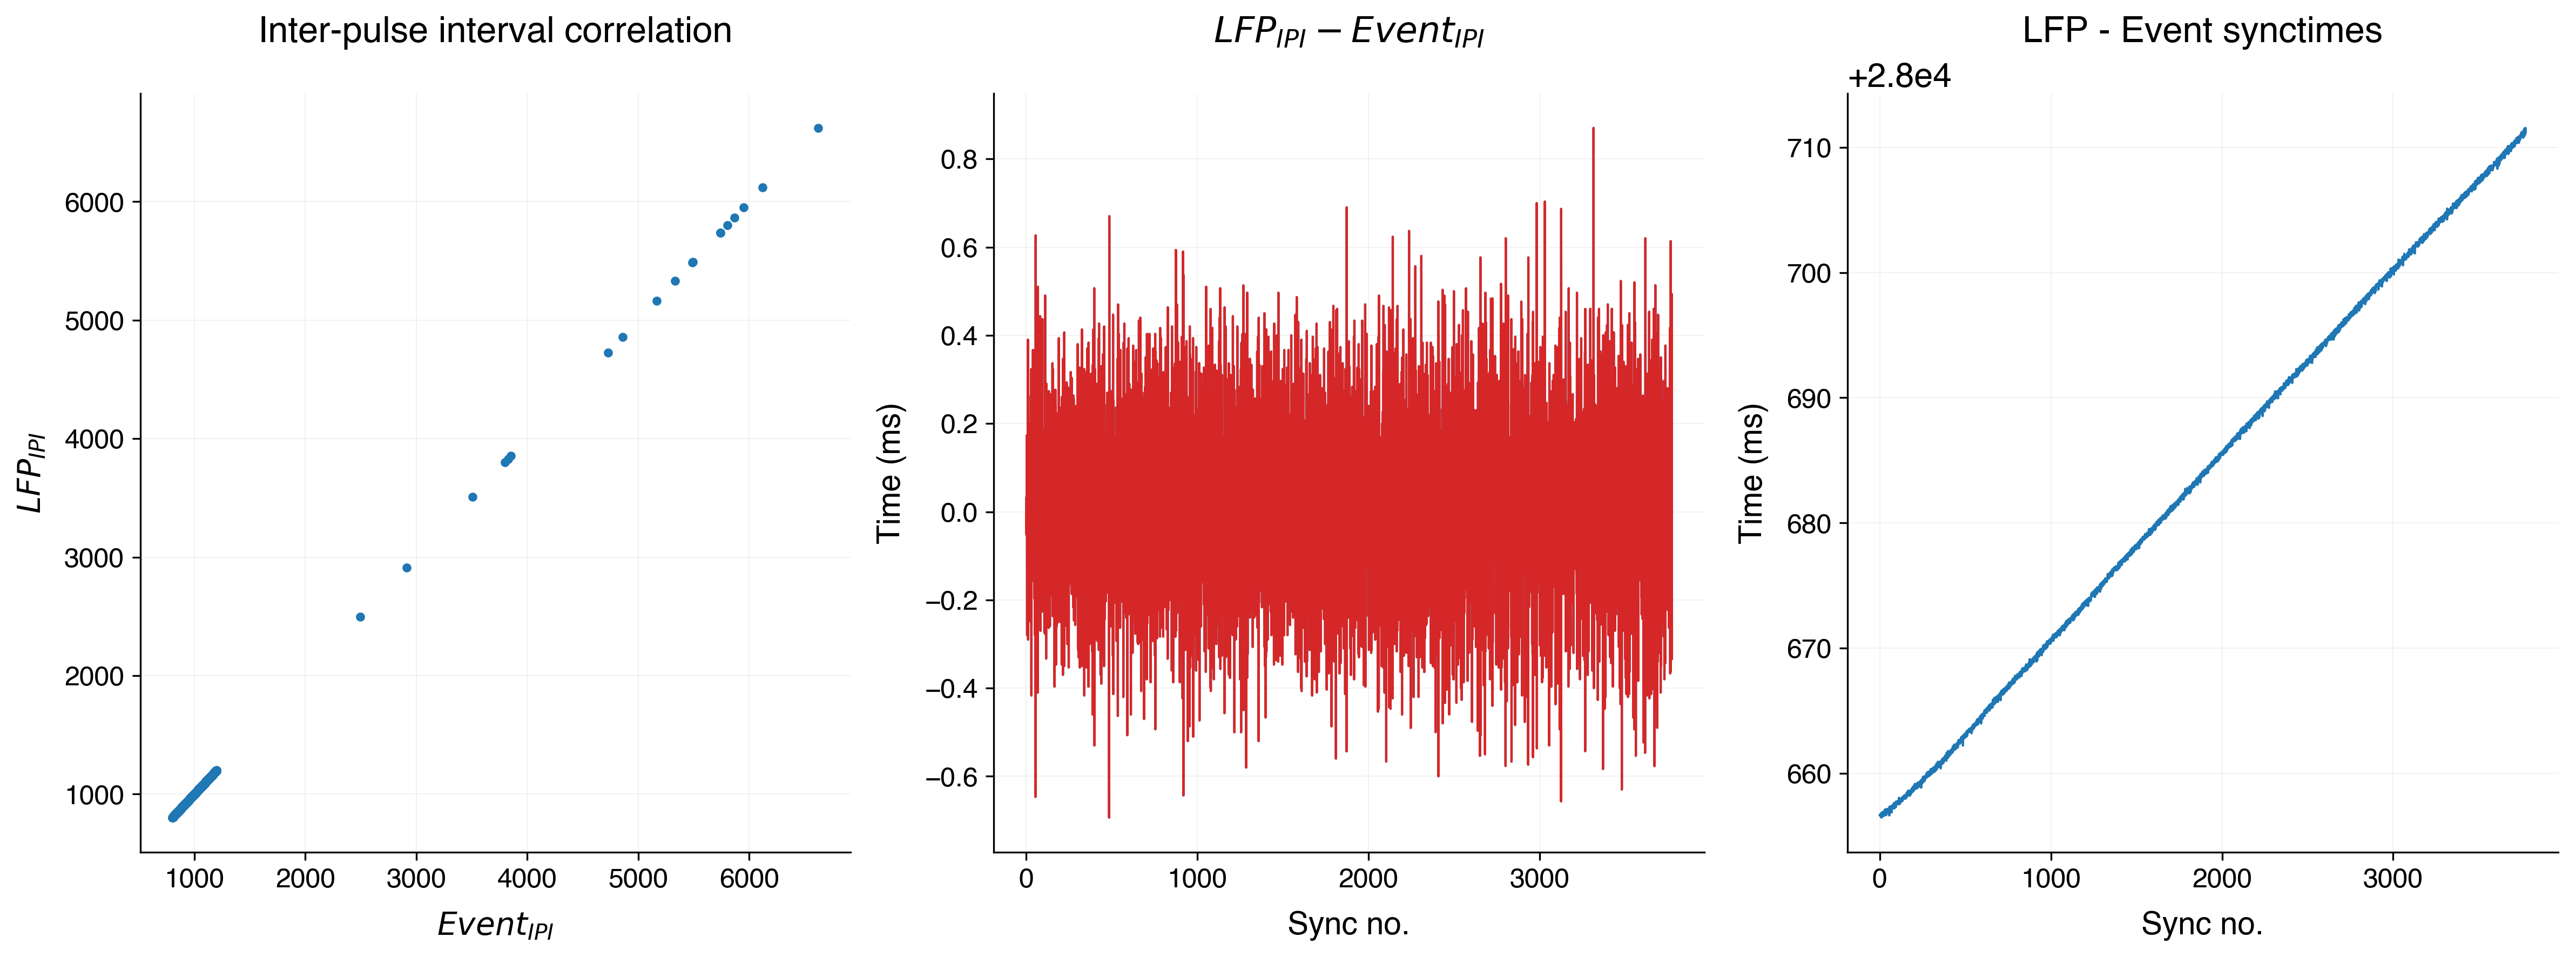

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
ax = np.ravel(ax)

min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
start = 0
stop = None

i = 0
ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

i = 1
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

i = 2
ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
fig.tight_layout()

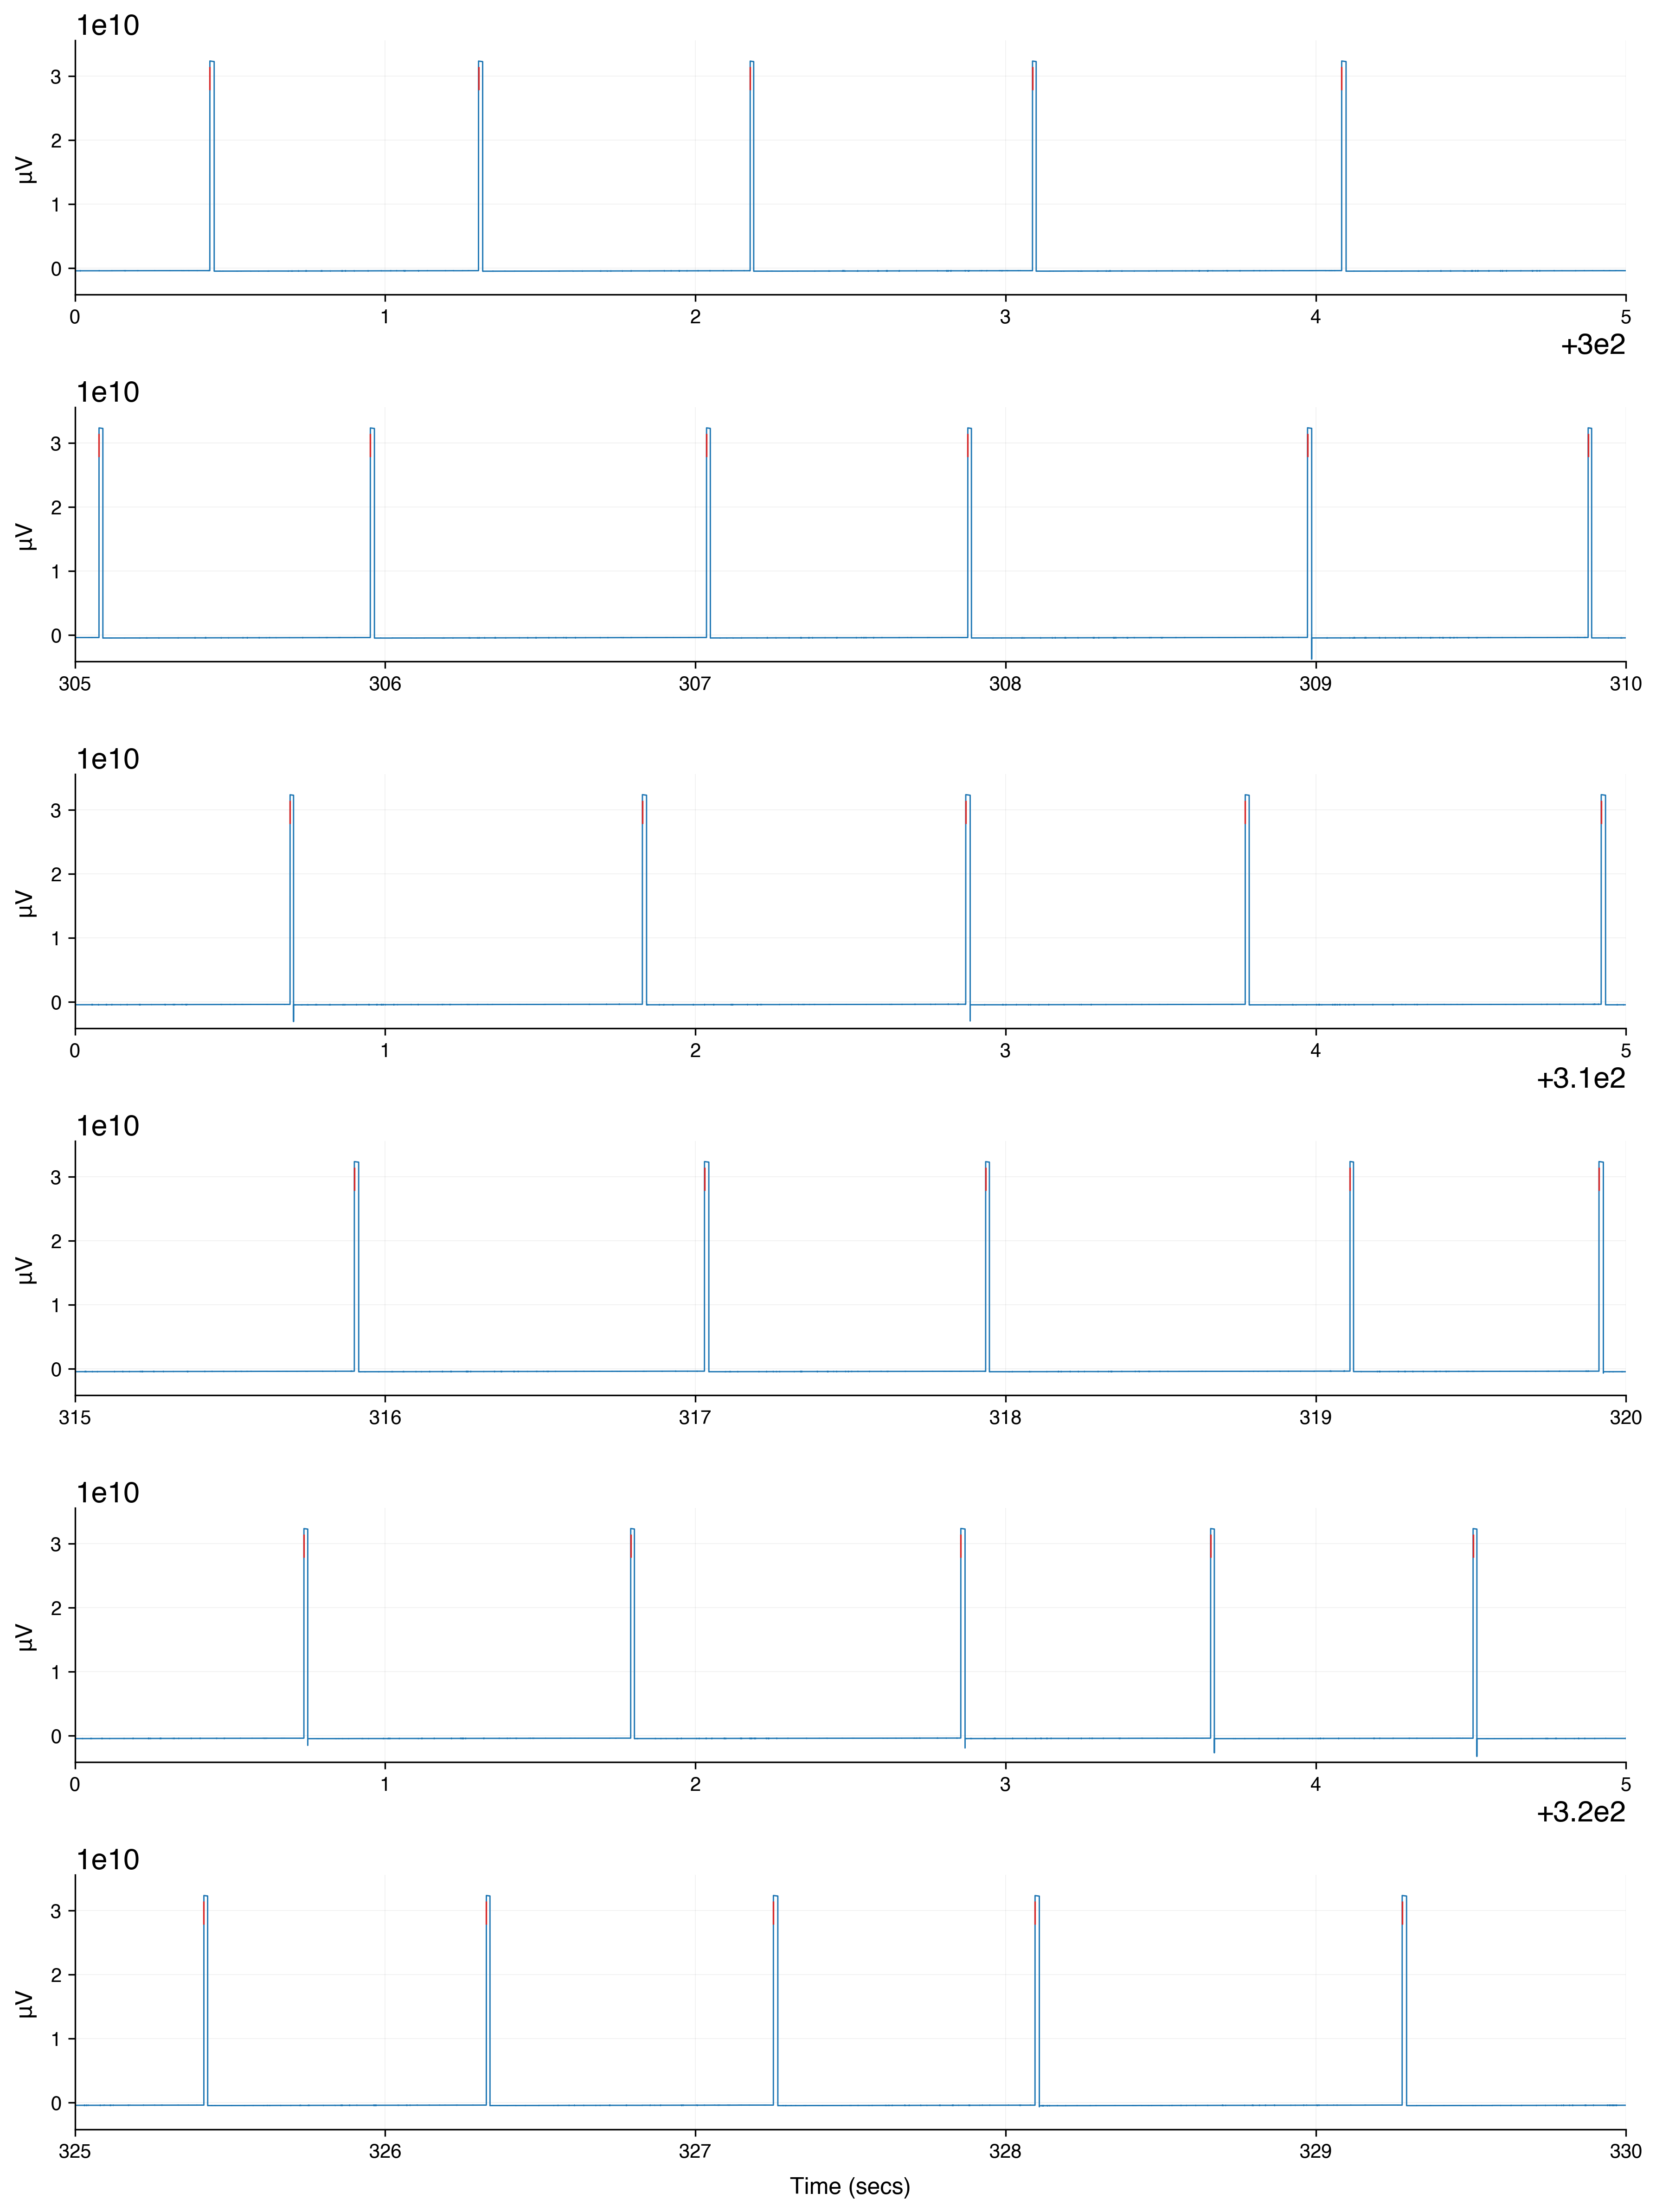

In [45]:
event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                              if x<len(lfp_timestamps)])).astype(np.int64)
event_pulse_startinds_train = np.zeros(len(sync_chan))
event_pulse_startinds_train[event_pulse_inds] = 1

fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                      start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)

## Format events and spikes

In [46]:
n_perms = 1000
verbose = True

start_time = time()

# Load events and event times.
events = events_preproc.format_events(events=events,
                                      overwrite=True,
                                      save_output=True,
                                      verbose=verbose)
game_states = ['Prepare1', 'Delay1', 'Encoding', 
               'Prepare2', 'Delay2', 'Retrieval']
event_times = events_preproc.create_event_time_bins(subj_sess,
                                                    events=events,
                                                    game_states=game_states,
                                                    overwrite=True,
                                                    save_output=False,
                                                    verbose=verbose)

# Save event time indices.
events = goldmine_behavior.Events(subj_sess)
_d = events.save_time_indices(overwrite=False)

# Load spikes.
spikes = spike_preproc.format_spikes(subj_sess,
                                     conv_factor='infer',
                                     fr_thresh=0.1,
                                     overwrite=True,
                                     save_output=False,
                                     verbose=verbose)

# Add spike time null distribution for each trial and trial phase.
spikes = spike_preproc.add_null_to_spikes(subj_sess,
                                          event_times,
                                          spikes=spikes,
                                          output_col='spike_times_null_trial_phase',
                                          n_perms=n_perms,
                                          save_output=True,
                                          split_files=True,
                                          verbose=verbose)

print('Done in {:.2f} s'.format(time() - start_time))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Removing incomplete trials and trials with a manual pause...

trial  gameState  
0      DoNextTrial    [incomplete]
       InitTrial      [incomplete]
Name: bad_trials, dtype: object

Main experiment has 76325 events recorded over 55 min and 10 sec
Saved /home1/dscho/projects/time_cells/analysis/events/U530_ses1-events_formatted.pkl
Conversion factor is 1
117432666 timestamps over 65 min and 14.4 s
Sampling rate is 30000 Hz
Found 96 wave_clus files.

Found 35 neurons
Firing rates:
count    35.000000
mean      7.108424
std       8.916112
min       0.231196
25%       1.209629
50%       3.068141
75%       8.671395
max      34.994692
Name: fr, dtype: float64

        unit  chan        fr
hemroi                      
LA         6     3  1.141931
LAC        1     1  2.354370
LEC       10     5  1.802309
LHGa      12     5  6.932313
RMH        6     4  6.212794
Saved /home1/dscho/projects/time_cells/analysis/spikes/U530_ses1-CSC9-unit1-spikes.pkl
Saved /home1/dscho/projects/time_cells/analysi